<a href="https://colab.research.google.com/github/hyuntaedo/Deep_learning/blob/main/FIFA_%EC%84%A0%EC%88%98_%EC%8B%9C%EC%9E%A5%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##EDA

#### 모듈설치

In [ ]:
!pip install Bayesian-Optimization

In [ ]:
!pip install -q xgboost

In [ ]:
!pip install -q ngboost

In [ ]:
!pip install mlxtend 

In [ ]:
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
#setting Package
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew
import seaborn as sns

# modeling package
from bayes_opt import BayesianOptimization
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from ngboost import NGBRegressor
from catboost import CatBoostRegressor

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/FIFA/FIFA_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/FIFA/FIFA_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/FIFA/submission.csv')

#### 데이터 확인

In [ ]:
train.head(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [ ]:
test.head(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0


#### 결측치 확인

In [ ]:
train.isna().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [ ]:
test.isna().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

## 데이터 전처리

In [ ]:
train.drop(['id','name'],axis=1,inplace=True)
test.drop(['id','name'],axis=1,inplace=True)

- 예측대상 컬럼의 왜도 확인

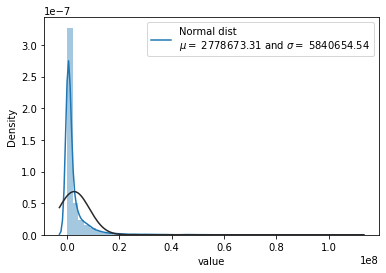

In [ ]:
sns.distplot(train.value, fit = norm)
(mu, sigma) = norm.fit(train['value'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

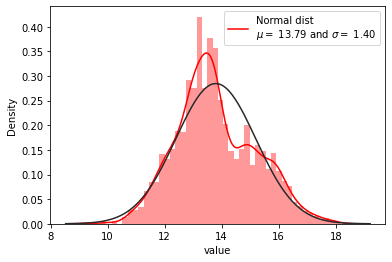

In [ ]:
sns.distplot(np.log1p(train.value), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(train['value']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

- 타겟값 로그 변환

In [ ]:
train.value = np.log1p(train.value)

- 계약기간에서 해당 데이터 제공년도를 뺀 '남은 계약기간' 변수 생성

In [ ]:
train['contract'] = 2018
test['contract'] = 2018

In [ ]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [ ]:
train.contract_until = train.contract_until.apply(con_period).astype('float64')
test.contract_until = test.contract_until.apply(con_period).astype('float64')

In [ ]:
train.contract_until -= train.contract
test.contract_until -= test.contract

In [ ]:
train.drop('contract',axis=1,inplace=True)
test.drop('contract',axis=1,inplace=True)

In [ ]:
train = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = train)
test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = test)

- 왜도가 높은 컬럼로그 변환

In [ ]:
X = train.drop('value',axis=1)
y = train.value

In [ ]:
X[['age','reputation','stat_potential']] = np.log1p(X[['age','reputation','stat_potential']])

In [ ]:
test[['age','reputation','stat_potential']] = np.log1p(test[['age','reputation','stat_potential']])

- StandardScaling

In [ ]:
scalar = StandardScaler()

In [ ]:
X = pd.DataFrame(scalar.fit_transform(X), columns= X.columns)

In [ ]:
test = pd.DataFrame(scalar.fit_transform(test),columns=test.columns)

## 모델링

#### NGBRegresosor

In [ ]:
ngb = NGBRegressor(random_state=2020)

In [ ]:
cv_ngb = cross_val_score(ngb,X,y,cv = KFold(n_splits=4,random_state=1011,shuffle=True),scoring='neg_mean_squared_error')
cv_ngb.mean()

[iter 0] loss=1.7590 val_loss=0.0000 scale=1.0000 norm=1.2891
[iter 100] loss=0.7767 val_loss=0.0000 scale=2.0000 norm=1.1218
[iter 200] loss=-0.0925 val_loss=0.0000 scale=2.0000 norm=0.9237
[iter 300] loss=-0.7624 val_loss=0.0000 scale=2.0000 norm=0.8157
[iter 400] loss=-1.0853 val_loss=0.0000 scale=2.0000 norm=0.8450
[iter 0] loss=1.7475 val_loss=0.0000 scale=1.0000 norm=1.2784
[iter 100] loss=0.7661 val_loss=0.0000 scale=2.0000 norm=1.1156
[iter 200] loss=-0.1014 val_loss=0.0000 scale=2.0000 norm=0.9212
[iter 300] loss=-0.7714 val_loss=0.0000 scale=2.0000 norm=0.8175
[iter 400] loss=-1.0888 val_loss=0.0000 scale=2.0000 norm=0.8573
[iter 0] loss=1.7558 val_loss=0.0000 scale=1.0000 norm=1.2850
[iter 100] loss=0.8024 val_loss=0.0000 scale=2.0000 norm=1.1342
[iter 200] loss=-0.0653 val_loss=0.0000 scale=2.0000 norm=0.9245
[iter 300] loss=-0.7359 val_loss=0.0000 scale=2.0000 norm=0.8125
[iter 400] loss=-1.0571 val_loss=0.0000 scale=1.0000 norm=0.4184
[iter 0] loss=1.7639 val_loss=0.0000 

-0.00856582127261347

In [ ]:
ngb.fit(X,y)

[iter 0] loss=1.7566 val_loss=0.0000 scale=1.0000 norm=1.2863
[iter 100] loss=0.7615 val_loss=0.0000 scale=2.0000 norm=1.1144
[iter 200] loss=-0.1036 val_loss=0.0000 scale=2.0000 norm=0.9212
[iter 300] loss=-0.7664 val_loss=0.0000 scale=2.0000 norm=0.8156
[iter 400] loss=-1.0822 val_loss=0.0000 scale=2.0000 norm=0.8468


NGBRegressor(Base=DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'),
             Dist=<class 'ngboost.distns.normal.Normal'>,
             Score=<class 'ngboost.scores.LogScore'>, col_sample=1.0,
             learning_rate=0.01, minibatch_frac=1.0, n_estimators=500,
             natural_gradient=True,
             random_state=RandomState(MT19937) at 0x7F805E100D10, tol=0.0001,
             verbose=True, verbose_eval=100)

In [ ]:
pred_ngb = np.expm1(ngb.predict(test))

### CatBoostRegressor

In [ ]:
param = {'depth':[2,3,4,5,6,7,8,9,10],'learning_rate':[0.0005, 0.001, 0.005, 0.01, 0.05 , 0.1 , 0.2 , 0.25]}

In [ ]:
grid_cat = GridSearchCV(CatBoostRegressor(random_state=1011),param,cv=KFold(n_splits=4,shuffle=True,random_state=1011),scoring='neg_mean_squared_error',n_jobs=-1)

In [ ]:
grid_cat.fit(X,y)

0:	learn: 1.1766980	total: 48.1ms	remaining: 48s
1:	learn: 0.9929251	total: 50.4ms	remaining: 25.2s
2:	learn: 0.8373167	total: 51.9ms	remaining: 17.2s
3:	learn: 0.7170664	total: 53.5ms	remaining: 13.3s
4:	learn: 0.6178283	total: 55ms	remaining: 10.9s
5:	learn: 0.5339420	total: 56.5ms	remaining: 9.35s
6:	learn: 0.4635013	total: 58.1ms	remaining: 8.24s
7:	learn: 0.4088383	total: 59.6ms	remaining: 7.39s
8:	learn: 0.3659289	total: 61.1ms	remaining: 6.72s
9:	learn: 0.3239334	total: 62.7ms	remaining: 6.21s
10:	learn: 0.2928689	total: 64.4ms	remaining: 5.79s
11:	learn: 0.2642994	total: 66ms	remaining: 5.43s
12:	learn: 0.2413847	total: 67.5ms	remaining: 5.12s
13:	learn: 0.2215522	total: 69ms	remaining: 4.86s
14:	learn: 0.2035851	total: 70.6ms	remaining: 4.63s
15:	learn: 0.1892678	total: 72.1ms	remaining: 4.43s
16:	learn: 0.1781422	total: 73.5ms	remaining: 4.25s
17:	learn: 0.1690731	total: 74.9ms	remaining: 4.08s
18:	learn: 0.1606283	total: 76.5ms	remaining: 3.95s
19:	learn: 0.1531369	total: 78

GridSearchCV(cv=KFold(n_splits=4, random_state=1011, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f80509fb250>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05,
                                           0.1, 0.2, 0.25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
cat = CatBoostRegressor(random_state = 2020,**grid_cat.best_params_)

In [ ]:
cat.fit(X,y)

0:	learn: 1.1694025	total: 1.98ms	remaining: 1.98s
1:	learn: 0.9841204	total: 4.4ms	remaining: 2.2s
2:	learn: 0.8340927	total: 7.77ms	remaining: 2.58s
3:	learn: 0.7056034	total: 9.77ms	remaining: 2.43s
4:	learn: 0.6079531	total: 11.6ms	remaining: 2.3s
5:	learn: 0.5308715	total: 13.5ms	remaining: 2.23s
6:	learn: 0.4633655	total: 15.4ms	remaining: 2.19s
7:	learn: 0.4025279	total: 17.3ms	remaining: 2.14s
8:	learn: 0.3536280	total: 19ms	remaining: 2.09s
9:	learn: 0.3193523	total: 20.6ms	remaining: 2.04s
10:	learn: 0.2835587	total: 22.2ms	remaining: 1.99s
11:	learn: 0.2570999	total: 24.5ms	remaining: 2.01s
12:	learn: 0.2347348	total: 26ms	remaining: 1.98s
13:	learn: 0.2180353	total: 27.6ms	remaining: 1.94s
14:	learn: 0.2026086	total: 29.4ms	remaining: 1.93s
15:	learn: 0.1891756	total: 30.8ms	remaining: 1.89s
16:	learn: 0.1776611	total: 32.8ms	remaining: 1.9s
17:	learn: 0.1682251	total: 34.3ms	remaining: 1.87s
18:	learn: 0.1604591	total: 36ms	remaining: 1.86s
19:	learn: 0.1538147	total: 37.8

In [ ]:
pred_cat = np.expm1(cat.predict(test))

### XGBoostRegressor + BayesianOptimization

In [ ]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.0001, 0.4),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5, 1),  
            'colsample_bytree': (0.5, 1),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample_bytree,   
        'gamma': gamma,
        'n_jobs' : -1,
        'random_state' : 777
    }
    
    xgb = XGBRegressor(**params)
    
    kf = KFold(n_splits = 4 , shuffle=True, random_state=50)

    score = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [ ]:
BO_xgb.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.01795  |  0.7744   |  3.576    |  0.2411   |  6.814    |  443.0    |  0.8229   |
|  2        | -0.02445  |  0.7188   |  4.459    |  0.3855   |  5.684    |  814.1    |  0.7644   |
|  3        | -22.44    |  0.784    |  4.628    |  0.02851  |  3.61     |  36.38    |  0.9163   |
|  4        | -0.02118  |  0.8891   |  4.35     |  0.3914   |  8.594    |  481.2    |  0.8903   |
|  5        | -0.01511  |  0.5591   |  3.2      |  0.05743  |  9.613    |  542.0    |  0.7073   |
|  6        | -0.01732  |  0.6323   |  3.871    |  0.1825   |  6.979    |  34.94    |  0.8088   |
|  7        | -0.02073  |  0.806    |  3.085    |  0.3775   |  7.773    |  378.4    |  0.7185   |
|  8        | -0.009018 |  0.8488   |  0.3011   |  0.2667   |  7.694    |  228.1    |  0.5645   |
|  9        | -0.015

In [ ]:
BO_xgb.max

{'params': {'colsample_bytree': 0.5077862500013182,
  'gamma': 0.04360905322972397,
  'learning_rate': 0.08216538168209876,
  'max_depth': 5.4789444222025185,
  'n_estimators': 570.2837921082393,
  'subsample': 0.8848282063597044},
 'target': -0.00530820637106056}

In [ ]:
params = BO_xgb.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

In [ ]:
xgb = XGBRegressor(random_state = 777, **params)

In [ ]:
xgb.fit(X, y)

[14:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5077862500013182,
             gamma=0.04360905322972397, importance_type='gain',
             learning_rate=0.08216538168209876, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=570, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=777,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8848282063597044, verbosity=1)

In [ ]:
pred_xgb = np.expm1(xgb.predict(test))

### LGBMRegressor + BayesianOptimization

In [ ]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'colsample_bytree': (0.5,1),   
            'num_leaves': (2,16),
            'min_child_weight': (1, 10)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMRegressor(**params)
    
    kf = KFold(n_splits=4 , shuffle=True, random_state=50)

    score = cross_val_score(lgbm, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    

In [ ]:
BO_lgbm.maximize(init_points=10, n_iter = 200)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.008573 |  0.7085   |  0.1442   |  3.001    |  3.721    |  163.9    |  3.293    |  0.5931   |
|  2        | -0.005609 |  0.6728   |  0.07966  |  6.772    |  4.773    |  706.7    |  4.862    |  0.9391   |
|  3        | -0.009932 |  0.5137   |  0.1343   |  5.921    |  6.028    |  157.5    |  4.773    |  0.9004   |
|  4        | -0.006451 |  0.9841   |  0.06303  |  7.846    |  8.888    |  917.8    |  3.191    |  0.5195   |
|  5        | -0.004511 |  0.5849   |  0.1757   |  3.688    |  4.79     |  981.6    |  9.464    |  0.8459   |
|  6        | -0.004874 |  0.6578   |  0.1375   |  8.842    |  1.165    |  772.1    |  15.84    |  0.8741   |
|  7        | -0.004528 |  0.6402   |  0.158    |  3.723    |  5.031    |  931.9    |  6.111    |  0.6439   |
|  8      

In [ ]:
BO_lgbm.max

{'params': {'colsample_bytree': 0.5849152097822845,
  'learning_rate': 0.17568942943416793,
  'max_depth': 3.688427836831351,
  'min_child_weight': 4.78996862504547,
  'n_estimators': 981.5526463917059,
  'num_leaves': 9.464313989622239,
  'subsample': 0.8459385569752367},
 'target': -0.004511167365824896}

In [ ]:
params = BO_lgbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['num_leaves'] = int(round(params['num_leaves']))

In [ ]:
lgbm = LGBMRegressor(seed = 1011, **params)

In [ ]:
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5849152097822845, importance_type='split',
              learning_rate=0.17568942943416793, max_depth=4,
              min_child_samples=20, min_child_weight=4.78996862504547,
              min_split_gain=0.0, n_estimators=982, n_jobs=-1, num_leaves=9,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              seed=1011, silent=True, subsample=0.8459385569752367,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred_lgbm = np.expm1(lgbm.predict(test))

### GradientBoostingRegressor + BayesianOptimization

In [ ]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 512),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}

def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingRegressor(**params)
    kf = KFold(n_splits = 4 , shuffle = True, random_state=50)
    score = cross_val_score(gbm, X, y, scoring='neg_mean_squared_error', cv = kf, n_jobs=-1)
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    

In [ ]:
BO_gbm.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.006316 |  0.11     |  8.006    |  3.411    |  3.635    |  226.1    |  0.8229   |
|  2        | -0.006231 |  0.0878   |  9.242    |  4.855    |  3.15     |  408.7    |  0.7644   |
|  3        | -0.01175  |  0.1138   |  9.479    |  1.284    |  2.261    |  26.03    |  0.9163   |
|  4        | -0.007091 |  0.1557   |  9.09     |  4.914    |  4.397    |  244.9    |  0.8903   |
|  5        | -0.005778 |  0.0241   |  7.479    |  1.573    |  4.834    |  274.8    |  0.7073   |
|  6        | -0.1413   |  0.05328  |  8.42     |  2.825    |  3.705    |  25.32    |  0.8088   |
|  7        | -0.005838 |  0.1226   |  7.319    |  4.775    |  4.045    |  194.3    |  0.7185   |
|  8        | -0.007559 |  0.1397   |  3.422    |  3.667    |  4.012    |  120.3    |  0.5645   |
|  9        | -0.005

In [ ]:
BO_gbm.max

{'params': {'learning_rate': 0.2,
  'max_depth': 3.0,
  'min_samples_leaf': 1.0,
  'min_samples_split': 5.0,
  'n_estimators': 510.02220977305916,
  'subsample': 1.0},
 'target': -0.004762067636553315}

In [ ]:
params = BO_gbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['min_samples_leaf'] = int(round(params['min_samples_leaf']))
params['min_samples_split'] = int(round(params['min_samples_split']))

In [ ]:
gbm = GradientBoostingRegressor(random_state = 123, **params)
gbm.fit(X, y)
pred_gbm = np.expm1(gbm.predict(test))

### VotingRegressor

In [ ]:
vot = VotingRegressor(estimators = [('lgbm', lgbm), ('xgb' ,xgb), ('gbm', gbm), ('cat', cat)], weights = [.2, .1, .3, .4])

In [ ]:
vot.fit(X, y)

[14:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 1.1694025	total: 1.96ms	remaining: 1.96s
1:	learn: 0.9841204	total: 3.84ms	remaining: 1.92s
2:	learn: 0.8340927	total: 5.25ms	remaining: 1.75s
3:	learn: 0.7056034	total: 6.92ms	remaining: 1.72s
4:	learn: 0.6079531	total: 8.57ms	remaining: 1.71s
5:	learn: 0.5308715	total: 10.3ms	remaining: 1.71s
6:	learn: 0.4633655	total: 11.9ms	remaining: 1.69s
7:	learn: 0.4025279	total: 13.6ms	remaining: 1.68s
8:	learn: 0.3536280	total: 15.2ms	remaining: 1.67s
9:	learn: 0.3193523	total: 16.8ms	remaining: 1.66s
10:	learn: 0.2835587	total: 19.1ms	remaining: 1.72s
11:	learn: 0.2570999	total: 20.7ms	remaining: 1.7s
12:	learn: 0.2347348	total: 22.2ms	remaining: 1.69s
13:	learn: 0.2180353	total: 23.7ms	remaining: 1.67s
14:	learn: 0.2026086	total: 25.2ms	remaining: 1.66s
15:	learn: 0.1891756	total: 26.7ms	remaining: 1.64s
16:	learn: 0.1776611	total: 28.4ms	remaining: 1.64s


VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=0.5849152097822845,
                                           importance_type='split',
                                           learning_rate=0.17568942943416793,
                                           max_depth=4, min_child_samples=20,
                                           min_child_weight=4.78996862504547,
                                           min_split_gain=0.0, n_estimators=982,
                                           n_jobs=-1, num_leaves=9,
                                           objective=None, random_state=None,
                                           reg_alph...
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                 

In [ ]:
pred_vot = np.expm1(vot.predict(test))

In [ ]:
stack = StackingCVRegressor(regressors = (gbm, lgbm), meta_regressor = xgb)

In [ ]:
stack.fit(np.array(X), y)

[14:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.5077862500013182,
                                                gamma=0.04360905322972397,
                                                importance_type='gain',
                                                learning_rate=0.08216538168209876,
                                                max_delta_step=0, max_depth=5,
                                                min_child_weight=1,
                                                missing=None, n_estimators=570,
                                                n_jobs=1, nthread=None,
                                                objecti...
                                  

In [ ]:
pred_stc = np.expm1(stack.predict(np.array(test)))

In [ ]:
submission['value'] = (pred_ngb + pred_cat + pred_xgb + pred_lgbm + pred_gbm + pred_vot + pred_stc) / 7

In [ ]:
submission['value'] = (pred_ngb * pred_cat * pred_xgb * pred_lgbm * pred_gbm * pred_vot * pred_stc) ** (1/7)

In [ ]:
q1 = submission['value'].quantile(0.0042)
q2 = submission['value'].quantile(0.99)

submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x*0.77)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x*1.1)

In [ ]:
submission

,id,value
0,1,6.390892e+07
1,2,9.964451e+07
2,4,8.994331e+07
3,5,9.417508e+07
4,6,6.657179e+07
...,...,...
3823,16924,5.806321e+04
3824,16929,5.016408e+04
3825,16932,5.923680e+04
3826,16937,4.972974e+04


In [ ]:
submission.to_csv('sub10112.csv', index = False)